# **Assignment 2 - Machine Translation**
#### **Due: October 6 (Thursday), 2022**

## **Notes**
### **Getting Started**

In order to compile code efficiently please pay attention to if you are using a hardware accelerator or not. If you are directly calling libraries like Tensorflow, Keras, or Pytorch, it is advised to switch to a GPU.

To access a GPU, go to `Edit->Notebook settings` and in the `Hardware accelerator` dropdown choose `GPU`. 
As soon as you run a code cell, you will be connected to a cloud instance with a GPU.
Try running the code cell below to check that a GPU is connected (select the cell then either click the play button at the top left or press `Ctrl+Enter` or `Shift+Enter`).

The free version of Google Colab will provide the necessary hardware for this course. Please keep in mind the RAM and Disk Space that you are allocated and that you are not given an infinite active runtime.

If your local machine has a GPU that you find outperforms the cloud GPU then you can follow the necessary documentation to use a GPU with your environment.

### **Lost GPU/TPU Access on Colab**

If you are not allocated a GPU or cannot connect to a GPU (limits are reached for Collab), Kaggle also provides free access to GPUs and TPUs. Please transfer your work to a Kaggle runtime instance by downloading your file on Colab as a '.ipynb' file and importing the file into Kaggle.

### **Submission Instructions**

We will use Gradescope for assignment submission. You can upload files individually or as part of a zip file, but if using a zip file be sure you are zipping the files directly and not a folder that contains them. Please note if designated output is cleared, you will receive a 0.

To download this notebook, go to `File->Download .ipynb`.  Please rename the file to match the name in our file list. 

When submitting your ipython notebooks, make sure everything runs correctly if the cells are executed in order starting from a fresh session.  Note that just because a cell runs in your current session doesn't mean it doesn't rely on code that you have already changed or deleted.  If the code doesn't take too long to run, we recommend re-running everything with `Runtime->Restart and run all...`.

When you upload your submission to the Gradescope assignment, you should get immediate feedback that confirms your submission was processed correctly.  Be sure to check this, as an incorrectly formatted submission could cause the autograder to fail.  For this project, you should be able to see your test set accuracies and a confirmation that all required files were found, but you will not be able to see your score until later.  Most assignments will be graded primarily on your test set accuracies, but we may also use other factors to grade.

Note that Gradesope will allow you to submit multiple times before the deadline, and we will use the latest submission for grading.


## Q1: IBM Model 1

This question will ask you to implement an IBM Model 1 trained on the first 100 samples of the dataset iwslt2017 English to German.
First review of the concepts and formulas of IBM Model 1 in the slides. Then follow the instructions below to implement it.

**You are not allowed to use nltk or other nature language processing library.**

In [3]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 432 kB 14.0 MB/s 
     |████████████████████████████████| 212 kB 45.9 MB/s 
     |████████████████████████████████| 115 kB 53.5 MB/s 
     |████████████████████████████████| 163 kB 49.2 MB/s 
     |████████████████████████████████| 127 kB 57.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [4]:
import datasets
import re
import numpy as np
from operator import itemgetter

### Load dataset from HuggingFace

In [5]:
dataset=datasets.load_dataset('wmt16','de-en')['train'][:100]['translation']

Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split:   0%|          | 0/4548885 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2999 [00:00<?, ? examples/s]

Dataset wmt16 downloaded and prepared to /root/.cache/huggingface/datasets/wmt16/de-en/1.0.0/746749a11d25c02058042da7502d973ff410e73457f3d305fc1177dc0e8c4227. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

### Define function for generating corpus and dictionary

In [6]:
def get_corpus(dataset):
  for sample in dataset:
    yield {'en':re.sub('[^A-Za-z_\']',' ',sample['en']).split(), 'de':re.sub('[^A-Za-z_\']',' ',sample['de']).split()}
def get_dict(dataset,lang):
  for sample in dataset:
    for word in re.sub('[^A-Za-z_\']',' ',sample[lang]).split():
      yield word

### Get corpus and dictionary

In [7]:
corpus=list(get_corpus(dataset))
print(corpus[99])
english_dict=set(get_dict(dataset,'en'))
print(english_dict)
german_dict=set(get_dict(dataset,'de'))
print(german_dict)

{'en': ['I', 'should', 'now', 'like', 'to', 'comment', 'on', 'the', 'issue', 'itself'], 'de': ['Jetzt', 'm', 'chte', 'ich', 'zur', 'Sache', 'selbst', 'etwas', 'sagen']}
{'so', 'raise', 'All', 'natural', 'meeting', 'Gonz', 'victims', 'legislative', 'amendments', 'week', 'young', 'saying', 'approved', 'shall', 'Hicks', 'reprieve', 'when', 'prior', 'regret', 'i', 'about', 'offices', 'irresponsible', 'done', 'expressed', 'peaceful', 'Mrs', 'introducing', 'Conference', 'truly', 'As', 'objectives', 'legislature', 'bearing', 'occasion', 'whatsoever', 'wrong', 'recently', 'expressing', 'votes', 'fellow', 'innocent', 'basically', 'Alternatively', 'should', 'pleasant', 'me', 'silence', 'weight', 'Why', 'enjoyed', 'answered', 'Brussels', 'these', 'there', 'soon', 'start', 'worry', 'suggesting', 'really', 'means', 'assassinated', 'aware', 'listen', 'enough', 'like', 'French', 'execution', 'Palacio', 'December', 'somewhat', 'specifically', 'no', 'producers', 'September', 'stability', "'millennium",

### Initialize probability and counts of the destination words

In [8]:
prob={en: {fr: 1/len(english_dict) for fr in german_dict} for en in english_dict} 
print(list(prob.values())[0:10])
total_en = {en: 0 for en in english_dict} 
print(total_en)

[{'Best': 0.0013157894736842105, 'so': 0.0013157894736842105, 'vereinbart': 0.0013157894736842105, 'Herrn': 0.0013157894736842105, 'All': 0.0013157894736842105, 'Verzicht': 0.0013157894736842105, 'Der': 0.0013157894736842105, 'stets': 0.0013157894736842105, 'bei': 0.0013157894736842105, 'zwei': 0.0013157894736842105, 'abgestimmt': 0.0013157894736842105, 'nder': 0.0013157894736842105, 'ne': 0.0013157894736842105, 'Meinung': 0.0013157894736842105, 'Auskunft': 0.0013157894736842105, 'programmatische': 0.0013157894736842105, 'Gonz': 0.0013157894736842105, 'ros': 0.0013157894736842105, 'legislative': 0.0013157894736842105, 'aber': 0.0013157894736842105, 'Zum': 0.0013157894736842105, 'ber': 0.0013157894736842105, 'nden': 0.0013157894736842105, 'land': 0.0013157894736842105, 'Arbeitsschutzregelungen': 0.0013157894736842105, 'gestellt': 0.0013157894736842105, 'Juli': 0.0013157894736842105, 'Milit': 0.0013157894736842105, 'Hicks': 0.0013157894736842105, 'instabil': 0.0013157894736842105, 'nur':

In [ ]:
from datasets.features.features import PandasArrayExtensionDtype
import numpy as np
from collections import defaultdict


length = len(corpus)
english_dict=set(get_dict(dataset,'en'))
german_dict=set(get_dict(dataset,'de'))
dict ={en: {} for en in english_dict} 


en_lst = []
de_lst = []

for i in range(100):
  lst1 = []
  lst2 = []

  for en in corpus[i]['en']:
    lst1.append(en)
  
  for de in corpus[i]['de']:
    lst2.append(de)

  en_lst.append(lst1)
  de_lst.append(lst2)
# print(en_lst)
# print(de_lst)

for i in range(1000):
  count = defaultdict(int)
  count_e = defaultdict(int)
  for e_lst, d_lst in zip(en_lst, de_lst):
    for de in d_lst:
      # print(e_lst)
      # e_lst.append("NULL")
      # print(d_lst)
      sum_e = 0
      for en in e_lst:
        sum_e += prob[en][de]
      for en in e_lst:
        count[(de,en)] += (prob[en][de] / float(sum_e))
        count_e[en] += (prob[en][de] / float(sum_e))

for (f,e) in count.keys():
  prob[e][f] = prob[e][f] * float(count[(f,e)]) / float(count_e[e])

print(list(prob.values())[1:10])





[{'will': 0.0013157894736842105, 'Billigung': 0.0013157894736842105, 'Beifall': 0.0013157894736842105, 'Gute': 0.0013157894736842105, 'Ihr': 0.0013157894736842105, 'rchtete': 0.0013157894736842105, 'Fischereipolitik': 0.0013157894736842105, 'sowie': 0.0013157894736842105, 'ausf': 0.0013157894736842105, 'einhalten': 0.0013157894736842105, 'All': 0.0013157894736842105, 'Kr': 0.0013157894736842105, 'Vorsitzende': 0.0013157894736842105, 'nde': 0.0013157894736842105, 'Wenn': 0.0013157894736842105, 'unverantwortlich': 0.0013157894736842105, 'tzen': 0.0013157894736842105, 'Zustimmung': 0.0013157894736842105, 'vorangegangenen': 0.0013157894736842105, 'niederl': 0.0013157894736842105, 'zweite': 0.0013157894736842105, 'nnen': 0.0013157894736842105, 'Da': 0.0013157894736842105, 'haben': 0.0013157894736842105, 'hnt': 0.0013157894736842105, 'Gem': 0.019916963510048707, 'an': 0.0013157894736842105, 'Sie': 0.024862844023761526, 'unternommen': 0.0013157894736842105, 'Europ': 0.034201954891207774, 'Gon

In [16]:
from datasets.features.features import PandasArrayExtensionDtype
import numpy as np
from collections import defaultdict


def step(prob, corpus, en_dict, de_dict,total_en):
  '''
  prob: probaility of alignment
  corpus: pairs of English to German sentence.
  en_dict: English dictionary.
  de_dict: German dictionary.
  total_en: counts of the destination words, weighted according to
             their translation probabilities t(e|s).
  
  '''
  counts = {en: {de: 0 for de in de_dict} for en in en_dict}
  total_de = {de: 0 for de in de_dict}
  # your answer here, update prob

  en_lst = []
  de_lst = []

  for i in range(100):
    lst1 = []
    lst2 = []

    for en in corpus[i]['en']:
      lst1.append(en)
  
    for de in corpus[i]['de']:
      lst2.append(de)

    en_lst.append(lst1)
    de_lst.append(lst2)
# print(en_lst)
# print(de_lst)

# HERE IS MY ITERATION

  for i in range(1):
    count = defaultdict(int)
    count_e = defaultdict(int)
    for e_lst, d_lst in zip(en_lst, de_lst):
      for de in d_lst:
        sum_e = 0
        for en in e_lst:
          sum_e += prob[en][de]
        for en in e_lst:
          count[(de,en)] += (prob[en][de] / float(sum_e))
          count_e[en] += (prob[en][de] / float(sum_e))

  for (f,e) in count.keys():
    prob[e][f] = float(count[(f,e)]) / float(count_e[e])

  return prob

In [20]:
iteration=1000
for i in range(iteration):
  prob=step(prob,corpus,english_dict,german_dict,total_en)

In [21]:
aligned_words={k: sorted(v.items(), key=itemgetter(1), reverse=True)[0][0] for (k, v) in prob.items()}

In [22]:
print(aligned_words)

{'so': 'Nach', 'raise': 'am', 'All': 'anderen', 'natural': 'Millenium', 'meeting': 'der', 'Gonz': 'Gonz', 'victims': 'ndern', 'legislative': 'als', 'amendments': 'Zu', 'week': 'Woche', 'young': 'Hicks', 'saying': 'Ihre', 'approved': 'politischen', 'shall': 'damit', 'Hicks': 'Hicks', 'reprieve': 'bei', 'when': 'wenn', 'prior': 'Aussprache', 'regret': 'von', 'i': 'Beginn', 'about': 'w', 'offices': 'an', 'irresponsible': 'einer', 'done': 't', 'expressed': 'deswegen', 'peaceful': 'von', 'Mrs': 'Frau', 'introducing': 'dar', 'Conference': 'Konferenz', 'truly': 'Millenium', 'As': 'die', 'objectives': 'Sozialdemokratische', 'legislature': 'Wahlperiode', 'bearing': 'dar', 'occasion': 'Der', 'whatsoever': 'Mitb', 'wrong': 'Entschlie', 'recently': 'ngster', 'expressing': 'von', 'votes': 'Stimmen', 'fellow': 'Mitb', 'innocent': 'einstreichen', 'basically': 'legislative', 'Alternatively': 'Bereitschaft', 'should': 'werden', 'pleasant': 'ne', 'me': 'Arbeitsschutzregelungen', 'silence': 'Schweigeminu

#### Use Google translate to verify some of the alignment result. Adjust the iteration number to see the difference. Discuss your throughts in the text bar below.

# Answer:
### Actually, I thought, maybe increasing the times of iteration will improve the accuray of this model, but I thought due to the limitation of our corpus, the result has not gain an expected effect, and I apply the IBM model1 to a larger dataset, it did can translate the sentence perfectly. Here is a link to that program: https://github.com/jesseLiu2000/CSE-527A-NLP.git

(You answer)

## Q2: Beam Search Decoding

In this section, you will implement a beam search algorithm for decoding. Assume we have a vocabulary of length 100, and sentence length 15. Run the greedy algorithm first, and implement the beam search algorithm below. Note that the return type of beam search algorihtm is sightly different from greedy algorithm.

In [3]:
import numpy as np
from functools import reduce
import math

In [4]:
DICTIONARY_LEN=100
SEQUENCE_LEN=15

In [7]:
def greedy_decoding(encoded):
  '''
  args:
  encoded: a sequence of probabilities of a vocabulary with size of [[prob]*length of dictionary]*length of sequence

  return:
  a sequence of the index of the the decoded word in dictionary. size=[index]*length of sentence
  '''
  return np.argmax(encoded,axis=1)

In [1]:
import torch
def beam_search_decoding(encoded, k):
  '''
  args:
  encoded: a sequence of probabilities of a vocabulary with size of [[prob]*length of dictionary]*length of sequence

  return:
  a sequence of sequence of the index of the the decoded word in dictionary. size= [[index]*length of sentence]*k
  '''
  #your answer here
  encoded = torch.log(torch.tensor(encoded) + 1e-12)

  value, indices = torch.topk(encoded[0], k=k)

  result = [ [i] for i in indices.tolist()]
  vocab_size = encoded.shape[1]
  for idx in range(1, encoded.shape[0]):
      # shape: (k, 1)
      value = value.unsqueeze(dim=1)
      # shape: (k, vocab_size)
      value = value + encoded[idx].unsqueeze(dim=0)
      # shape: k * vocab_size
      value = value.view(-1)
      # topk
      value, indices = torch.topk(value, k=k)

      pre_indices = [i // vocab_size for i in indices.tolist()]
      indices = [i % vocab_size for i in indices.tolist()]
      result = [result[pre_indices[idx]] + [indices[idx]] for idx in range(k)]
  output_sequences = np.array(result)
  return output_sequences

### Here is version only use Numpy, I dont knwo whether the Prof. allowed us used Pytorch, thus I update this version

In [ ]:
import numpy as np

def beam_search_decoding(encoded, k):
  '''
  args:
  encoded: a sequence of probabilities of a vocabulary with size of [[prob]*length of dictionary]*length of sequence

  return:
  a sequence of sequence of the index of the the decoded word in dictionary. size= [[index]*length of sentence]*k
  '''
  #your answer here
  encoded = np.log(encoded + 1e-12)

  indices = np.argsort(-encoded[0])
  value, indices = encoded[0][indices[0:k]], indices[0:k]

  result = [ [i] for i in indices.tolist()]
  vocab_size = encoded.shape[1]
  for idx in range(1, encoded.shape[0]):
      # shape: (k, 1)
      value = value.reshape(-1, 1)
      # shape: (k, vocab_size)
      value = value + encoded[idx].reshape(1, -1)
      # shape: k * vocab_size
      value = value.reshape(-1)
      # topk
      indices = np.argsort(-value)
      value, indices = value[indices[0:k]], indices[0:k]

      pre_indices = [i // vocab_size for i in indices.tolist()]
      indices = [i % vocab_size for i in indices.tolist()]
      result = [result[pre_indices[idx]] + [indices[idx]] for idx in range(k)]
  return np.array(result)

In [5]:
np.random.seed(0)
encoded_sequence=np.random.uniform(0,1,size=(SEQUENCE_LEN,DICTIONARY_LEN))

In [8]:
greedy_decoded=greedy_decoding(encoded_sequence)
print(greedy_decoded)

[52 49 10 49 78 95 19 66 65 74 28 25 98 19 27]


In [9]:
beam_decoded=beam_search_decoding(encoded_sequence,3)
print(beam_decoded)

[[52 49 10 49 78 95 19 66 65 74 28 25 98 19 27]
 [52 49 10 77 78 95 19 66 65 74 28 25 98 19 27]
 [52 49 10 95 78 95 19 66 65 74 28 25 98 19 27]]


### Q3: Attention

We will implement the multi-head self attention algorithm in this question using Pytorch. fill out the "forward" method in the classes below.


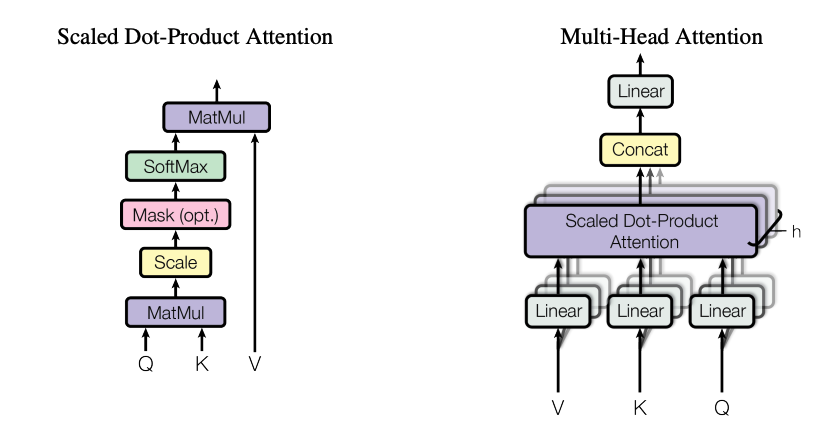

In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import math
from einops import rearrange
import numpy as np

In this section, we will implement a class that takes q, k, v, and output:
$$
attention(q,k,v)=softmax(qk^\top/\sqrt{d_k})v
$$

In [ ]:
class ScaledDotProductAttention(nn.Module):
  ''' Scaled Dot-Product Attention '''

  def __init__(self):
    super(ScaledDotProductAttention,self).__init__()

  def forward(self, q, k, v):
    '''
    args:
    q: the query features BxLxd_k. B=batch size, L=sequence lenth, d_k=query&key dimension.
    k: the key features BxLxd_k.
    v the value features BxLxd_v. d_v=value dimension
    return:
    value: softmax((qk^T)/sqrt(d_k))v, BxLxd_v
    '''
    # your answer here
    d_k = k.size(2)
    scores = torch.matmul(q, k.transpose(-1, -2)) / np.sqrt(d_k)
    attention = nn.Softmax(dim = -1)(scores)
    value = torch.matmul(attention, v)
    return value

In this section, we will implement a class that takes word embeddings, computes q,k,v for different heads, and use the class we implement above to generate the attentional value for each head. Then it will concatnate the value of each head and linearly transform back to the dimension of word embeddings. Finally a residual operation and a layer norm is applied

Note that the output of "self.qkv_transform" has the shape of (BxLx(num_heads*(d_q+d_k+d_v))). Be careful with the order of q,k,v(query first, key second, value last)

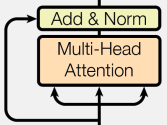


In [ ]:
from IPython.core.display import Video
class MultiHeadAttention(nn.Module):
  ''' Multi-Head Attention module '''

  def __init__(self, n_head, d_model, d_k, d_v):
    '''
    n_head: number of heads,
    d_model: number of word embedding dimension
    d_k: key dimension
    d_v: value dimension
    '''
    super(MultiHeadAttention,self).__init__()

    self.n_head = n_head
    self.d_k = d_k
    self.d_v = d_v

    self.qkv_transform = nn.Linear(d_model, n_head * (d_k*2+d_v), bias=False)
    self.fc = nn.Linear(n_head * d_v, d_model, bias=False)
    self.attention = ScaledDotProductAttention()
    self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
    # you can replace following initialization code for your future application, this is just for testing, but don't replace it when you submit the assignment.
    torch.manual_seed(0)
    torch.nn.init.normal_(self.qkv_transform.weight)
    torch.manual_seed(0)
    torch.nn.init.normal_(self.fc.weight)
    self.layer_norm.weight.data.fill_(1.0)    
    self.layer_norm.bias.data.fill_(0.0)

  def forward(self, x):
    '''
    args:
    x: word embeddings BxLxd_model, B=batch size, L=sequence length, d_model=word embeddings dimension
    return:
    value: BxLxd_model
    '''
    # your answer here

    batch_size, sequence_length, d_model = x.size(0), x.size(1), x.size(2)
    residual = x  # [batch_size x len_q x d_model]

    # [batch_size x n_heads x len_q x d_k]   

    QKV = self.qkv_transform(x).view(batch_size, -1, self.n_head, self.d_k).transpose(1,2)
    Q = QKV[:, :, :sequence_length, :] 
    K = QKV[:, :, sequence_length:2*sequence_length, :]
    V = QKV[:, :, 2*sequence_length:, :]

    # print(Q.shape)
    # [batch_size x n_heads x len_q x d_k]
 
    
    context = self.attention(Q, K, V)
    context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_v) 

    output = self.fc(context)
    value = self.layer_norm(output + residual)
    return value  # [batch_size x len_q x d_model]

In [ ]:
MHSA=MultiHeadAttention(6,32,32,32)
torch.manual_seed(0)
# [batch_size x len_q x d_model]
x=torch.randn(5,15,32)
y=MHSA(x)

print(y[0,0,:3])


torch.Size([5, 6, 15, 32])
tensor([-0.8787,  0.0237, -0.9344], grad_fn=<SliceBackward0>)
